In [1]:
from fretbursts import *
sns = init_notebook()
full_fname='LS3.h5'
d = loader.photon_hdf5(full_fname)
loader.alex_apply_period(d)
d.calc_bg(bg.exp_fit, time_s=10, tail_min_us='auto', F_bg=2)

 - Optimized (cython) burst search loaded.
 - Optimized (cython) photon counting loaded.
--------------------------------------------------------------
 You are running FRETBursts (version 0.6.5+7.g10955f6).

 If you use this software please cite the following paper:

   FRETBursts: An Open Source Toolkit for Analysis of Freely-Diffusing Single-Molecule FRET
   Ingargiola et al. (2016). http://dx.doi.org/10.1371/journal.pone.0160716 

--------------------------------------------------------------
# Total photons (after ALEX selection):    28,822,970
#  D  photons in D+A excitation periods:   14,784,567
#  A  photons in D+A excitation periods:   14,038,403
# D+A photons in  D  excitation period:    21,713,037
# D+A photons in  A  excitation period:     7,109,933

 - Calculating BG rates ... [DONE]


In [2]:
d.burst_search(m=10, computefret=False, ph_sel=Ph_sel(Dex='DAem'))
d.calc_fret(count_ph=True, corrections=False)
d.leakage = 0.07

 - Performing burst search (verbose=False) ... - Recomputing background limits for Dex ... [DONE]
 - Recomputing background limits for all ... [DONE]
 - Fixing  burst data to refer to ph_times_m ... [DONE]
[DONE]
 - Calculating burst periods ...[DONE]
   - Applying leakage correction.


 - - - - - CHANNEL  1 - - - - 
 --> END Fused 34403 bursts (23.6%, 13 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   [DONE Counting D/A and FRET]


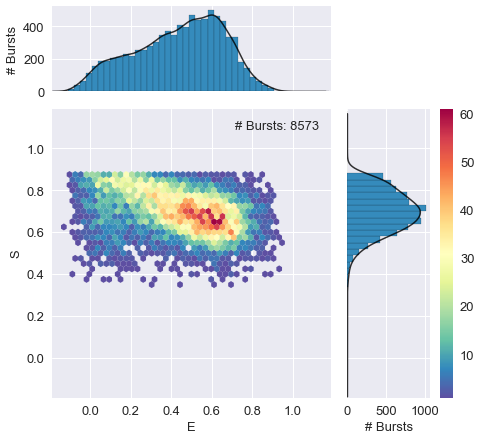

In [3]:
ds = d.select_bursts(select_bursts.naa, th1=1, computefret=False)
ds = ds.fuse_bursts(ms=0)
ds1 = ds.select_bursts(select_bursts.size, th1=30,computefret=False)
ds_FRET = ds1.select_bursts(select_bursts.S, S1=0.2, S2=0.88,computefret=False)

dx=ds_FRET
alex_jointplot(dx)

 - - - - - CHANNEL  1 - - - - 
 --> END Fused 5502 bursts (14.3%, 6 iter)

 - Counting D and A ph and calculating FRET ... 
   - Applying background correction.
   - Applying leakage correction.
   [DONE Counting D/A and FRET]
   - Applying background correction.
   - Applying leakage correction.


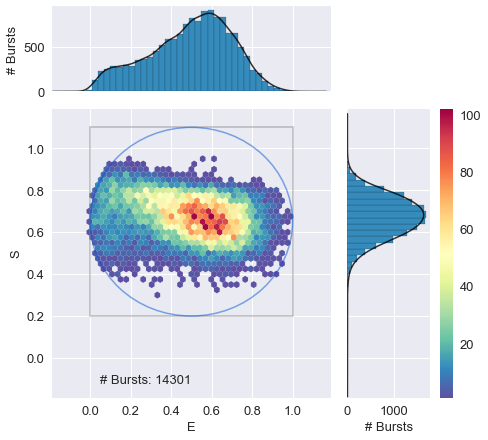

In [4]:
ds = d.select_bursts(select_bursts.naa, th1=7, computefret=False)
ds = ds.fuse_bursts(ms=0)
ds1 = ds.select_bursts(select_bursts.size, computefret=False)
# ds_FRET = ds1.select_bursts(select_bursts.S, S1=0.2, S2=0.86)
# ds_FRET.leakage = 0.07
# dx=ds_FRET
# alex_jointplot(dx)
roi = dict(E1=0, E2=1, S1=0.2, S2=1.1, rect=False)
ds_FRET = ds1.select_bursts(select_bursts.ES, **roi,computefret=False)
ds_FRET.leakage = 0.07
g = alex_jointplot(ds_FRET)
bpl.plot_ES_selection(g.ax_joint, **roi);

In [5]:
ds_FRET.E
import scipy.io as sio
from array import array
sio.savemat('fret.mat', {'fret':ds_FRET.E[0]})

In [6]:
def bva_sigma_E(n, bursts, DexAem_mask, out=None):
    """
    Perform BVA analysis computing std.dev. of E for sub-bursts in each burst.
    
    Split each burst in n-photons chunks (sub-bursts), compute E for each sub-burst,
    then compute std.dev. of E across the sub-bursts.

    For details on BVA see:

    - Torella et al. (2011) Biophys. J. doi.org/10.1016/j.bpj.2011.01.066
    - Ingargiola et al. (2016) bioRxiv, doi.org/10.1101/039198

    Arguments:
        n (int): number of photons in each sub-burst
        bursts (Bursts object): burst-data object with indexes relative 
            to the Dex photon stream.
        DexAem_mask (bool array): mask of A-emitted photons during D-excitation 
            periods. It is a boolean array indexing the array of Dex timestamps 
            (`Ph_sel(Dex='DAem')`).
        out (None or list): append the result to the passed list. If None,
            creates a new list. This is useful to accumulate data from
            different spots in a single list.

    Returns:
        E_sub_std (1D array): contains for each burst, the standard deviation of 
        sub-bursts FRET efficiency. Same length of input argument `bursts`.
    """
    E_sub_std = [] if out is None else out
    
    for burst in bursts:
        E_sub_bursts = []
        startlist = range(burst.istart, burst.istop + 2 - n, n)
        stoplist = [i + n for i in startlist]
        for start, stop in zip(startlist, stoplist):
            A_D = DexAem_mask[start:stop].sum()
            assert stop - start == n
            E = A_D / n
            E_sub_bursts.append(E)
        E_sub_std.append(np.std(E_sub_bursts))
        
    return E_sub_std

In [7]:
ph_d = ds_FRET.get_ph_times(ph_sel=Ph_sel(Dex='DAem'))
bursts = ds_FRET.mburst[0]
bursts_d = bursts.recompute_index_reduce(ph_d)

Dex_mask = ds_FRET.get_ph_mask(ph_sel=Ph_sel(Dex='DAem'))   
DexAem_mask = ds_FRET.get_ph_mask(ph_sel=Ph_sel(Dex='Aem')) 
DexAem_mask_d = DexAem_mask[Dex_mask]

In [8]:
Dex_mask[:10]

array([ True,  True, False,  True,  True, False,  True, False,  True,  True], dtype=bool)

In [9]:
DexAem_mask[:10]

array([ True, False, False,  True, False, False,  True, False,  True, False], dtype=bool)

In [10]:
DexAem_mask_d[:10]

array([ True, False,  True, False,  True,  True, False,  True,  True, False], dtype=bool)

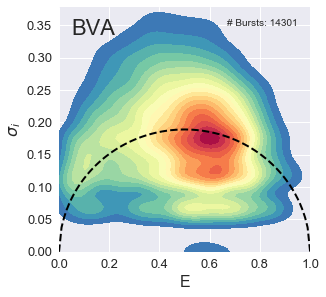

In [11]:
n = 7
E_sub_std = bva_sigma_E(n, bursts_d, DexAem_mask_d)

plt.figure(figsize=(4.5, 4.5))
x = np.arange(0,1.01,0.01)
y = np.sqrt((x*(1-x))/n)
plt.plot(x, y, lw=2, color='k', ls='--')
im = sns.kdeplot(ds_FRET.E[0], np.asfarray(E_sub_std), 
                 shade=True, cmap='Spectral_r', shade_lowest=False, n_levels=20)
plt.xlim(0,1)
plt.ylim(0,np.sqrt(0.5**2/7)*2)
plt.xlabel('E', fontsize=16)
plt.ylabel(r'$\sigma_i$', fontsize=16);
plt.text(0.05, 0.95, 'BVA', va='top', fontsize=22, transform=plt.gca().transAxes)
plt.text(0.95, 0.95, '# Bursts: %d' % ds_FRET.num_bursts, 
         va='top', ha='right', transform=plt.gca().transAxes)
plt.savefig('BVA.png', bbox_inches='tight', dpi=200, transparent=False)

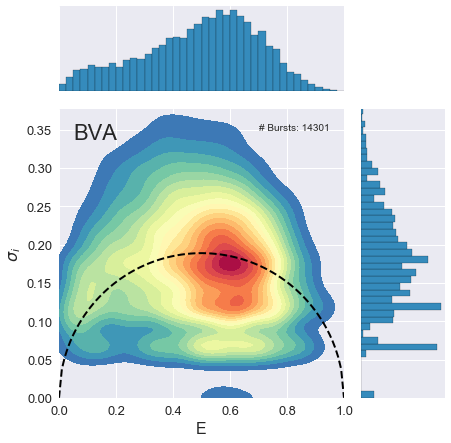

In [12]:
x, y = ds_FRET.E[0], np.asfarray(E_sub_std)
hist_kws = dict(edgecolor='k', linewidth=0.2,
                facecolor=sns.color_palette('Spectral_r', 100)[10])

g = sns.JointGrid(x=x, y=y, ratio=3)
g.plot_joint(sns.kdeplot, cmap='Spectral_r', shade=True, shade_lowest=False, n_levels=20)
g.ax_marg_x.hist(x, bins=np.arange(-0.2, 1.2, 0.025), **hist_kws)
g.ax_marg_y.hist(y, bins=50, orientation="horizontal", **hist_kws)

x1 = np.arange(0,1.01,0.01)
y1 = np.sqrt((x1*(1-x1))/n)
plt.plot(x1, y1, lw=2, color='k', ls='--')

g.ax_joint.set_xlim(0,1)
g.ax_joint.set_ylim(0,np.sqrt(0.5**2/7)*2)
g.ax_joint.set_xlabel('E', fontsize=16)
g.ax_joint.set_ylabel(r'$\sigma_i$', fontsize=16);
g.ax_joint.text(0.05, 0.95, 'BVA', va='top', fontsize=22, transform=g.ax_joint.transAxes)
g.ax_joint.text(0.95, 0.95, '# Bursts: %d' % ds_FRET.num_bursts, 
         va='top', ha='right', transform=g.ax_joint.transAxes)
plt.savefig('BVA_joint.png', bbox_inches='tight', dpi=200, transparent=False)